Loaded cube shape: (145, 145, 200), label map shape: (145, 145)
Shape after bad-band removal: (145, 145, 181)
Applying PCA → 30 spectral components
Final cube shape: (145, 145, 30)


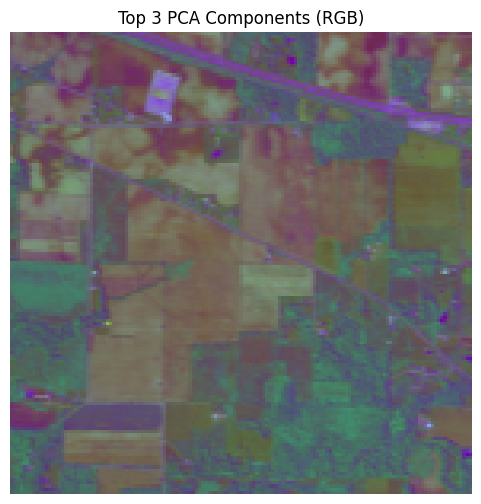

Total labeled patches: 10249 | Classes: 16
Epoch 001 | Val Acc: 0.2400
Epoch 002 | Val Acc: 0.3463
Epoch 003 | Val Acc: 0.4624
Epoch 004 | Val Acc: 0.5395
Epoch 005 | Val Acc: 0.5580
Epoch 006 | Val Acc: 0.5902
Epoch 007 | Val Acc: 0.6244
Epoch 008 | Val Acc: 0.6137
Epoch 009 | Val Acc: 0.6849
Epoch 010 | Val Acc: 0.6829
Epoch 011 | Val Acc: 0.6966
Epoch 012 | Val Acc: 0.7171
Epoch 013 | Val Acc: 0.7580
Epoch 014 | Val Acc: 0.7668
Epoch 015 | Val Acc: 0.7561
Epoch 016 | Val Acc: 0.7893
Epoch 017 | Val Acc: 0.7873
Epoch 018 | Val Acc: 0.8137
Epoch 019 | Val Acc: 0.7454
Epoch 020 | Val Acc: 0.8371
Epoch 021 | Val Acc: 0.8312
Epoch 022 | Val Acc: 0.8273
Epoch 023 | Val Acc: 0.8410
Epoch 024 | Val Acc: 0.8468
Epoch 025 | Val Acc: 0.8810
Epoch 026 | Val Acc: 0.8741
Epoch 027 | Val Acc: 0.8878
Epoch 028 | Val Acc: 0.8810
Epoch 029 | Val Acc: 0.8810
Epoch 030 | Val Acc: 0.8663
Epoch 031 | Val Acc: 0.9102
Epoch 032 | Val Acc: 0.8907
Epoch 033 | Val Acc: 0.8878
Epoch 034 | Val Acc: 0.9093
Epoch

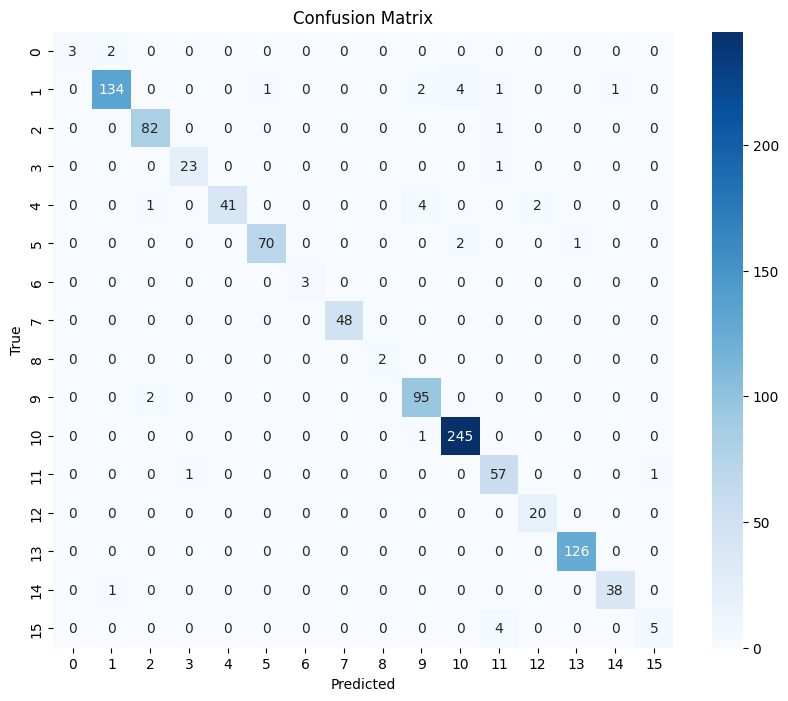

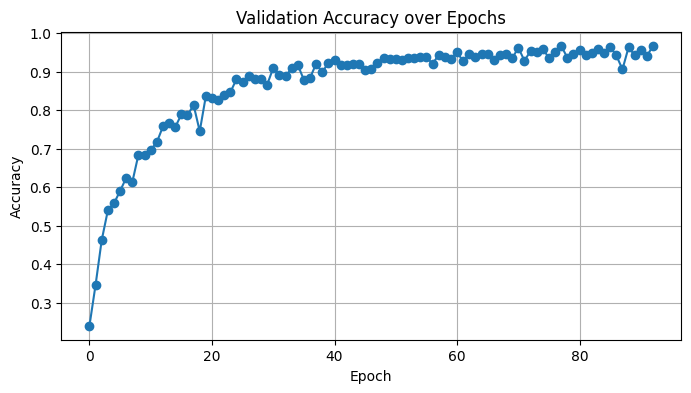

In [1]:
# ==============================================================
# 3‑D CNN for Indian Pines Hyperspectral Image Classification
# ==============================================================

# --------------------------------------------------------------
# 1. WorkFlow
# --------------------------------------------------------------
import os, math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PATCH_SZ   = 19
N_PRINC    = 30
VAL_FRAC   = 0.10
BATCH_SZ   = 128
EPOCHS     = 200
PATIENCE   = 15
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

os.makedirs("outputs", exist_ok=True)

# --------------------------------------------------------------
# 2. Load local .mat files (place in /content in Colab)
# --------------------------------------------------------------
img_path = "/content/Indian_pines_corrected.mat"
gt_path  = "/content/Indian_pines_gt.mat"

assert os.path.isfile(img_path), f" File not found: {img_path}"
assert os.path.isfile(gt_path),  f" File not found: {gt_path}"

cube_raw = loadmat(img_path)["indian_pines_corrected"]
labels   = loadmat(gt_path)["indian_pines_gt"]

print(f"Loaded cube shape: {cube_raw.shape}, label map shape: {labels.shape}")

# --------------------------------------------------------------
# 3. Remove water-absorption bands safely
# --------------------------------------------------------------
bad_bands = list(range(103,108)) + list(range(149,163)) + [219]
valid_bad = [b for b in bad_bands if b < cube_raw.shape[2]]
cube_raw  = np.delete(cube_raw, valid_bad, axis=2)
print(f"Shape after bad-band removal: {cube_raw.shape}")

# --------------------------------------------------------------
# 4. Normalize & Apply PCA
# --------------------------------------------------------------
cube = cube_raw.astype(np.float32)
cube = (cube - cube.min()) / (cube.max() - cube.min())

if N_PRINC and N_PRINC < cube.shape[2]:
    print(f"Applying PCA → {N_PRINC} spectral components")
    h, w, bands = cube.shape
    X2d = cube.reshape(-1, bands)
    pca = PCA(n_components=N_PRINC, whiten=True, random_state=RANDOM_SEED)
    X_pca = pca.fit_transform(X2d)
    cube  = X_pca.reshape(h, w, N_PRINC).astype(np.float32)

print(f"Final cube shape: {cube.shape}")

# Optional visualization: top 3 PCA bands
if cube.shape[2] >= 3:
    rgb_img = cube[:, :, :3]
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_img)
    plt.title("Top 3 PCA Components (RGB)")
    plt.axis("off")
    plt.savefig("outputs/pca_rgb.png")
    plt.show()

# --------------------------------------------------------------
# 5. Extract labeled 3-D patches
# --------------------------------------------------------------
margin = PATCH_SZ // 2
h, w, b = cube.shape
padded = np.pad(cube, ((margin, margin),(margin, margin),(0,0)), mode="reflect")

patches, patch_labels = [], []
for r in range(margin, h + margin):
    for c in range(margin, w + margin):
        lab = labels[r - margin, c - margin]
        if lab == 0:
            continue
        patch = padded[r - margin:r + margin + 1,
                       c - margin:c + margin + 1]
        patch = patch.transpose(2, 0, 1)[None, ...]
        patches.append(patch)
        patch_labels.append(lab - 1)

patches      = np.stack(patches)
patch_labels = np.array(patch_labels, dtype=np.int64)
n_classes    = patch_labels.max() + 1
print(f"Total labeled patches: {len(patches)} | Classes: {n_classes}")

# --------------------------------------------------------------
# 6. Dataset & DataLoader
# --------------------------------------------------------------
class HSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_X, val_X, train_y, val_y = train_test_split(
    patches, patch_labels, test_size=VAL_FRAC, stratify=patch_labels,
    random_state=RANDOM_SEED)

train_ds, val_ds = HSIDataset(train_X, train_y), HSIDataset(val_X, val_y)
train_dl = DataLoader(train_ds, batch_size=BATCH_SZ, shuffle=True, drop_last=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SZ)

# --------------------------------------------------------------
# 7. Define 3‑D CNN Model
# --------------------------------------------------------------
class SpectralSpatial3DCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv3d(1,  8, (7,3,3), padding=(0,1,1)), nn.ReLU(),
            nn.Conv3d(8, 16, (5,3,3), padding=(0,1,1)), nn.ReLU(),
            nn.Conv3d(16,32, 3, padding=1),             nn.ReLU(),
            nn.AdaptiveAvgPool3d(1)
        )
        self.fc = nn.Linear(32, n_classes)

    def forward(self, x):
        x = self.backbone(x).view(x.size(0), -1)
        return self.fc(x)

model = SpectralSpatial3DCNN(n_classes).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# --------------------------------------------------------------
# 8. Training Loop with Early Stopping
# --------------------------------------------------------------
best_acc, patience_counter = 0.0, 0
val_acc_list = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

    # --- validate ---
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            preds = model(xb).argmax(1)
            correct += (preds == yb).sum().item()
            total   += len(yb)
    val_acc = correct / total
    val_acc_list.append(val_acc)
    print(f"Epoch {epoch:03d} | Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "outputs/best_3dcnn_ip.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(" Early stopping")
            break

# --------------------------------------------------------------
# 9. Evaluation and Visualization
# --------------------------------------------------------------
model.load_state_dict(torch.load("outputs/best_3dcnn_ip.pth"))
model.to(DEVICE)
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(DEVICE)
        y_true.append(yb.numpy())
        y_pred.append(model(xb).argmax(1).cpu().numpy())
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# --- Metrics ---
print("\n📊 Classification Report:")
report = classification_report(y_true, y_pred, digits=4)
print(report)

acc_score = np.mean(y_true == y_pred)
print("Accuracy:", acc_score)
kappa = cohen_kappa_score(y_true, y_pred)
print("Kappa Score:", kappa)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# --- Save Report ---
with open("outputs/classification_report.txt", "w") as f:
    f.write(report)

# --- Confusion Matrix Plot ---
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("outputs/confusion_matrix.png")
plt.show()

# --- Accuracy Plot ---
plt.figure(figsize=(8, 4))
plt.plot(val_acc_list, marker="o")
plt.title("Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.savefig("outputs/accuracy_curve.png")
plt.show()
